## 0) INSTALLS

1. Using a mounted drive (or local installation) is recommended 
2. The following code will install packages for our analysis this week; installations will take >= 6 minutes and *it's best to not spend an hour of your life re-installing it* :)

See Debug tips if you have installation errors

In [1]:
## mount Google drive (optional, recommended)
## DEBUG TIP ##
## when restarting session, be sure to run first two lines (else you can comment out)
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/bioe_190_290/
!mkdir -p /content/drive/MyDrive/bioe_190_290/pythonpkg/
!mkdir -p /content/drive/MyDrive/bioe_190_290/assignment4/

## set working dir (feel free to change)
%cd /content/drive/MyDrive/bioe_190_290/project/

Mounted at /content/drive
/content/drive/MyDrive/bioe_190_290/project


In [2]:
%%capture
## NOTE: %%capture removes the outputs -- if you have an import/install error (etc)
## you should remove the line. Otherwise, let this cell run for ~10 minutes on your 
## first installation (on subsequent runs this should be instantaneous as it skips)

pkg_contents = !ls /content/drive/MyDrive/bioe_190_290/pythonpkg/
do_install = len(pkg_contents) < 10 

## this umap dependency has to be reinstalled each time (it's quick!)
!pip install pynndescent 

if do_install:
  !pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ scprep phate tasklogger igraph
  !pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ umap-learn magic-impute louvain

pheno_install = !ls /content/drive/MyDrive/bioe_190_290/pythonpkg | grep pheno
pheno_install = len(pheno_install) < 1

if pheno_install:
  !pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ git+https://github.com/dpeerlab/phenograph.git

## this is IMPORTANT -- otherwise python won't be able to find 
import sys
if sys.path[0] != '/content/drive/MyDrive/bioe_190_290/pythonpkg/':
  sys.path.insert(0, '/content/drive/MyDrive/bioe_190_290/pythonpkg/')

In [3]:
import pandas as pd
import numpy as np
import scprep, umap ## sometimes this takes 2-3 minutes in a new session  
# import phate

import sklearn
import sklearn.cluster
import sklearn.manifold
# import graphtools as gt
# import magic
import phenograph
import louvain
import matplotlib.pyplot as plt
import os

%matplotlib inline 

<ipython-input-3-8c441d587d4a>:12: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


# Importing your data

#### Loading text data (csv/tsv/txt)


In [4]:
## Read in the MYELOID counts 
heart_counts = scprep.io.load_csv( '/content/drive/MyDrive/bioe_190_290/project/Heart-counts.csv',
                          cell_axis='row', sparse=True).transpose()

## NOTE: the original Myeloid dataset is transposed, so we correct it here

heart_counts.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
B12.MAA000398.3_9_M.1.1,0.0,272.0,93.0,65.0,1.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,68.0,1.0,0.0,0.0,17.0,0.0
D16.MAA000398.3_9_M.1.1,0.0,21.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,0.0,0.0,389.0,3.0,6.0,0.0,41.0,0.0
F10.MAA000398.3_9_M.1.1,0.0,54.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41.0,0.0,28.0,45.0,0.0,31.0,0.0,19.0,0.0
L17.MAA000398.3_9_M.1.1,0.0,21.0,0.0,27.0,0.0,27.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50.0,38.0,0.0,0.0,11.0,0.0
N18.MAA000398.3_9_M.1.1,0.0,73.0,82.0,66.0,0.0,0.0,58.0,0.0,0.0,68.0,...,0.0,22.0,0.0,14.0,97.0,99.0,124.0,0.0,39.0,0.0


In [5]:
## Read in the NON-MYELOID counts 
aorta_counts = scprep.io.load_csv( '/content/drive/MyDrive/bioe_190_290/project/Aorta-counts.csv',
                          cell_axis='row', sparse=True).transpose()

aorta_counts.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A21.MAA000594.3_8_M.1.1,0.0,406.0,714.0,0.0,358.0,0.0,0.0,0.0,0.0,242.0,...,0.0,0.0,0.0,0.0,1150.0,0.0,0.0,0.0,345.0,0.0
D1.MAA000594.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,142.0,0.0,0.0,0.0,0.0,0.0
F8.MAA000594.3_8_M.1.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H11.MAA000594.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,281.0,0.0,0.0,0.0,0.0
N15.MAA000594.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we can combine our datasets into a single combined data matrix. If you wish, you may first apply library size filtering to each batch individually, as described in section 2.3, but this is not strictly necessary.

In [6]:
data = [heart_counts, aorta_counts]
batch_labels = ['Heart', 'Aorta']

## this combines batches together into a single DataFrame
data, sample_labels = scprep.utils.combine_batches(data, batch_labels)

### 2.1 Creating the metadata matrix


In [20]:
lookup = pd.Series(data.index).apply(lambda x: x.split('.')[1])

## adjust the path to metadata_FACS.csv as needed
metadata = pd.read_csv('metadata_FACS.csv', index_col=0).loc[lookup.values].reset_index()
metadata.index = data.index

metadata.head()

data.shape

(7115, 23433)

In [21]:
data.columns

Index(['0610005C13Rik', '0610007C21Rik', '0610007L01Rik', '0610007N19Rik',
       '0610007P08Rik', '0610007P14Rik', '0610007P22Rik', '0610008F07Rik',
       '0610009B14Rik', '0610009B22Rik',
       ...
       'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'l7Rn6', 'zsGreen_transgene'],
      dtype='object', length=23433)

### 2.2. Library size filtering

#### Visualing the library size distribution using `scprep`

There is a helper function for plotting library size from a gene expression matrix in scprep called [`scprep.plot.plot_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_library_size).

In [22]:
data.index

Index(['B12.MAA000398.3_9_M.1.1_Heart', 'D16.MAA000398.3_9_M.1.1_Heart',
       'F10.MAA000398.3_9_M.1.1_Heart', 'L17.MAA000398.3_9_M.1.1_Heart',
       'N18.MAA000398.3_9_M.1.1_Heart', 'H15.MAA000398.3_9_M.1.1_Heart',
       'J14.MAA000398.3_9_M.1.1_Heart', 'B14.MAA000398.3_9_M.1.1_Heart',
       'D17.MAA000398.3_9_M.1.1_Heart', 'F14.MAA000398.3_9_M.1.1_Heart',
       ...
       'O14.B002431.3_39_F.1.1_Aorta', 'F9.B002431.3_39_F.1.1_Aorta',
       'H14.B002431.3_39_F.1.1_Aorta', 'P20.B002431.3_39_F.1.1_Aorta',
       'J13.B002431.3_39_F.1.1_Aorta', 'K20.B002431.3_39_F.1.1_Aorta',
       'M5.B002431.3_39_F.1.1_Aorta', 'N12.B002431.3_39_F.1.1_Aorta',
       'O15.B002431.3_39_F.1.1_Aorta', 'P21.B002431.3_39_F.1.1_Aorta'],
      dtype='object', length=7115)

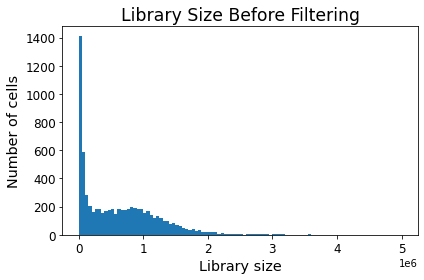

In [23]:
scprep.plot.plot_library_size(data,
                              log=False, title='Library Size Before Filtering')

Choose cutoffs above and below the main bulk of cells, removing cells that are both significantly smaller than average and significantly larger than average. You can plot the result by running `scprep.plot.plot_library_size` with `cutoff=(low, high)` or `percentile=(low, high)` where low and high are values or percentiles that you choose.

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


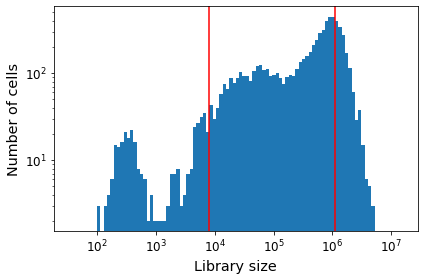

In [24]:
# =============
## TODO ##
## Select appropriate percentiles (percentile=(low, high))
## low should **probably** be something between 0 and 30
## high should **probably** be something between 80 and 100 


percentiles = (5, 80)

## This visualization will help you choose good high and low values
## change your percentiles, then see how the graph changes when re-run!!
 
scprep.plot.plot_library_size(data, percentile=percentiles)
# =============

## TODO ##
## What made you select the percentiles that you did? Justify your answer briefly :) 
# NOTE: there is no "correct" answer, just decent and decent-er ones. Justify your choices. 
#
#
#
#
#

#### Selecting a cutoff

### Exercise 1 - Filtering cells by library size

You can do this using [`scprep.filter.filter_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.filter.filter_library_size).

In [25]:
# ==================
# fill in your chosen `percentile` values
percentiles =  (5, 80)
data, metadata = scprep.filter.filter_library_size(data, metadata, percentile=percentiles)
# ==================

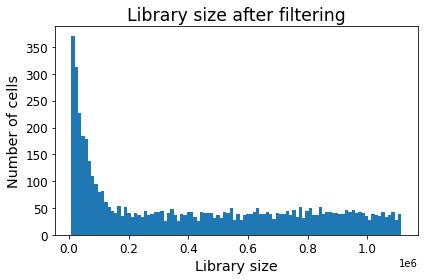

In [26]:
scprep.plot.plot_library_size(data, log=False, title='Library size after filtering')

The library size distribution is now much more constrained, which will reduce the effects of differences in library size (which can affect your results, even after normalization).

<a id='preprocessing'></a>
## 3. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size (if we did not do this prior to combining batches)
3. Removing genes that are expressed in relatively few cells.

### 3.1 - Filtering lowly expressed genes

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


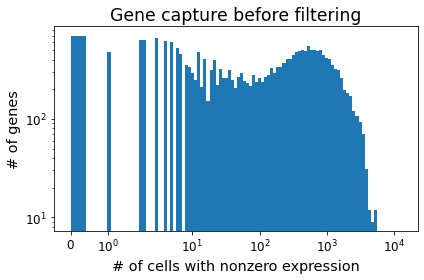

In [27]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

### Exercise 3 - filtering rare genes

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


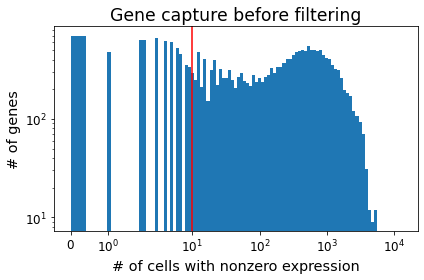

In [28]:
# ================
# choose a cutoff
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff = 10,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')
# ================

Let's go ahead and remove those genes.

In [29]:
# ================
# choose a cutoff
cutoff = 10
data = scprep.filter.filter_rare_genes(data, min_cells=cutoff)
# ================

We can plot the above histogram again for good measure. As you can see, the rare genes are all gone.

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


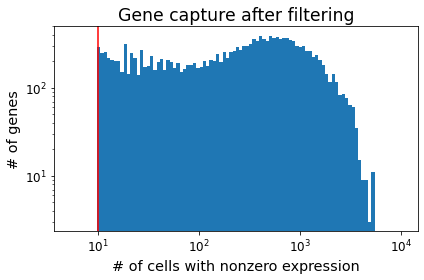

In [30]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [31]:
data.shape

(5336, 18069)

After filtering, we have removed many thousands of genes. This will be our last filtering step, though you can always filter out aberrant expression on an ad hoc basis. As it stands, we've quite significantly reduced our dataset from 10,000 x 33,000 that we started with. And that's not even counting the cells we removed by library size before combining time points!

### 3.2 - Normalization

As you saw during filtering, the range of library sizes between cells can be quite extreme. We visualized this for one time point pre-filtering, but let's now visualize the whole dataset, post-filtering.

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


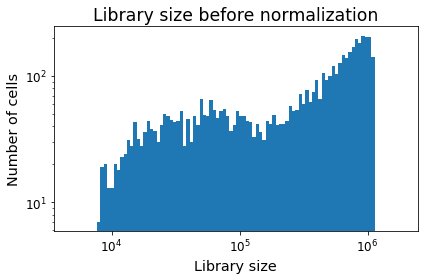

In [32]:
scprep.plot.plot_library_size(data, title='Library size before normalization')

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the a fixed value, sometimes the median library size. The default in `scprep` is to rescale every cell to 10,000 counts to make numbers comparable across datasets.

In python this is performed using the preprocessing method [`scprep.normalize.library_size_normalize()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.normalize.library_size_normalize).

In [33]:
data, metadata['library_size'] = scprep.normalize.library_size_normalize(data, return_library_size=True)

If you plot the library sizes again, you'll see they are all the same.

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


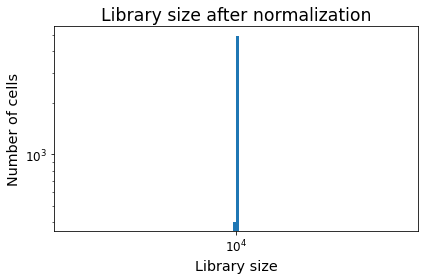

In [34]:
scprep.plot.plot_library_size(data, title='Library size after normalization')

### 3.3 - Gene Count Transformation

In scRNA-seq analysis, we often see that some genes are orders of magnitude more common than others. Let's have a look at the mean expression of each gene.

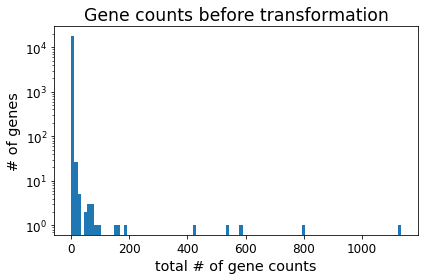

In [35]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In order to avoid these high-expression genes dominating the variation, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [36]:
data = scprep.transform.sqrt(data)

After transformation, you should see that the mean expression values are now much closer together.

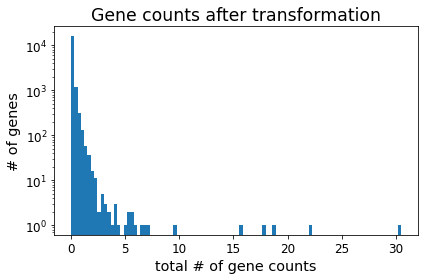

In [37]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

# Dimensionality reduction

## 6. Visualization using Principle Components Analysis (PCA)

Here we're going to use the simplest dimensionality reduction method first. We don't expect PCA to work well because the dataset is so complex, but it's a good place to start with any dataset.

#### Running PCA on the data

In [38]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [39]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
B12.MAA000398.3_9_M.1.1_Heart,-51.183193,30.363860,-3.592751,-4.757246,-3.084546,6.962515,9.393195,8.667270,-1.824873,-11.660266,...,-2.770539,-0.373172,-5.401857,2.121280,2.110059,-0.497904,3.626088,1.424337,0.656922,-0.950611
D16.MAA000398.3_9_M.1.1_Heart,-39.654012,-24.493714,-22.478274,-6.753250,-7.769206,10.188593,6.045794,8.469445,-2.263503,-12.236434,...,-1.807785,1.873409,2.526988,-2.554334,-1.031952,6.378589,-0.522222,1.484845,0.306616,2.777465
F10.MAA000398.3_9_M.1.1_Heart,-41.799301,-5.261475,-7.132560,-0.650968,7.686777,20.576325,32.009427,-4.300327,-10.098352,5.348136,...,-2.324105,-3.599933,0.683079,1.540274,0.311917,-1.401416,1.700951,-0.206295,-1.081393,-1.601736
L17.MAA000398.3_9_M.1.1_Heart,-42.054663,-3.624196,-8.682733,-1.364501,7.023625,24.274251,33.418822,-2.819932,-10.388260,6.799491,...,-2.876713,-2.514031,1.530425,0.761671,-0.062535,-3.046186,0.574889,-0.312801,-1.250601,-0.097046
N18.MAA000398.3_9_M.1.1_Heart,-49.654071,30.778007,5.260298,-6.956019,3.623799,-3.209044,5.071307,4.813801,0.575454,-6.696134,...,4.591802,-4.342410,-1.899067,-1.553472,-0.619394,-1.400341,-0.277185,1.148679,0.719368,0.989207


#### Plotting PCs using `scprep.plot`

The scprep package has a number of handy plotting features that act as a wrapper to `matplotlib`. You should know how to use `matplotlib` for more complicated plotting, but you can make all the plots we need in this tutorial with some help from `scprep`.

The full documentaiton of `scprep.plot` can be found here:

https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.plot

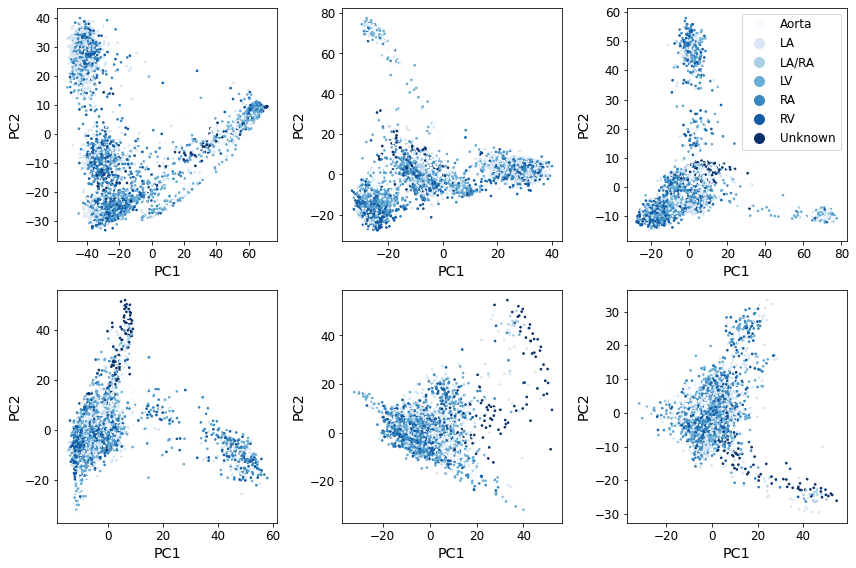

In [65]:
# Create a figure (the background) and a set of axes (the things we plot on)
fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['subtissue'],
                        cmap='Blues', ax=ax,
                        label_prefix="PC", legend=legend)
fig.tight_layout()

#### Plotting expression of a gene on the first two PCs

Now let's plot expression of some genes!


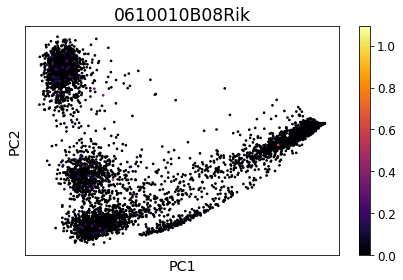

In [54]:
## we have filled this in for you, figure it out below 
expression = scprep.select.select_cols(data, exact_word='0610010B08Rik')

# we will sort cells by maximum expression so we can see where the gene is expressed
sort_index = expression.sort_values().index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title='0610010B08Rik', ticks=None, label_prefix='PC')

## 6.1. Embedding Data Using UMAP

The syntax for UMAP is based on many sklearn packages: `umap.UMAP().fit_transform`. UMAP is relatively fast, so you **won't need to use the subsampled data.**

UMAP's `n_neighbors` parameter describes the size of the neighborhood around each point. The `min_dist` parameter describes how tightly points can be packed together. The authors recommend values between 2 and 200 for `n_neighbors`, and between 0 and 0.99 for `min_dist`. Try a range of different values in and outside of these ranges and discuss the results with your group.

If you would like, feel free to play around with the `min_dist` and `n_neighbors` parameters.

In [55]:
import umap
data_umap = umap.UMAP().fit_transform(data_pca.iloc[:,:50])

In [56]:
data_umap = pd.DataFrame(data_umap, index = data.index)

In [ ]:
%matplotlib inline

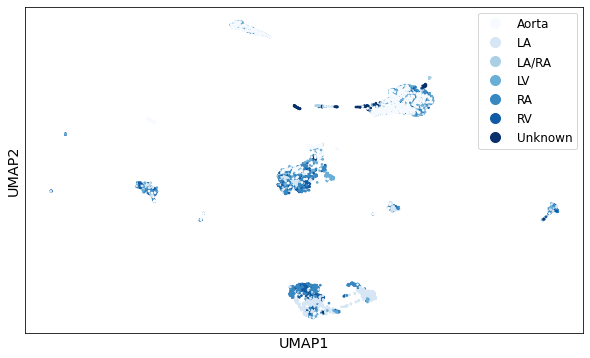

In [66]:
# ================
# Plot the UMAP coordinates
# **colored by subtissue** 
## (we have filled in the coloring for you)
fig, ax = plt.subplots(figsize=(10,6)) ## feel free to adjust size

scprep.plot.scatter2d(data_umap,  shuffle=False, ticks=None,
                      c=metadata['subtissue'], ax=ax, cmap='Blues', label_prefix="UMAP"
)
# ================

#### Let's look at some marker genes!

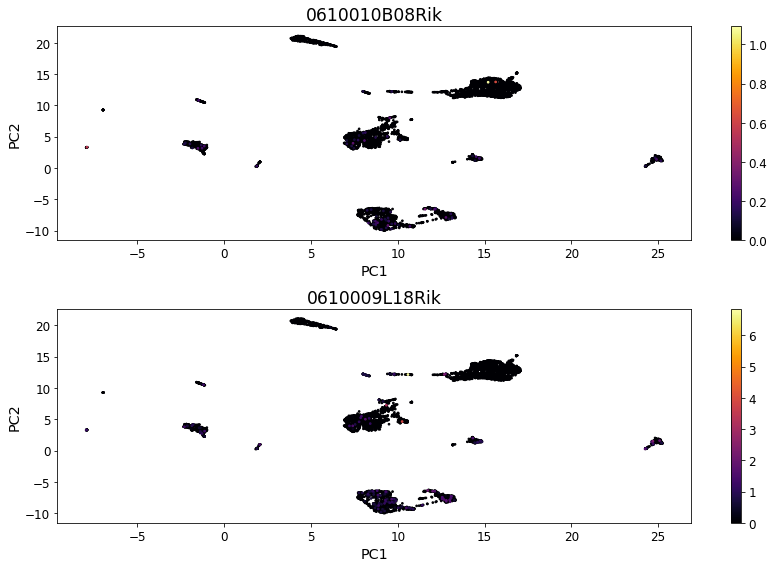

In [123]:
genes_for_plotting = ['0610010B08Rik', '0610009L18Rik']
# ================
# Plot two subplots of the UMAP coordinates
# coloring by Sp1 and Rn45s
fig, axes = plt.subplots(2,1, figsize=(12,8))

for gene, ax in zip(genes_for_plotting, axes.flatten()):
    expression = scprep.select.select_cols(data, exact_word=gene)
    sort_index = expression.sort_values().index

    scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index],shuffle=False,
                     title=gene, label_prefix='PC', ax=ax)
                          
## HINT: this uses a for loop structure instead of manually indexed in the 
## previous examples. Be sure to use the gene **variables** as needed.
## We have filled in the ax=ax keyword argument for you 

# ================

fig.tight_layout()

Misc (optional, ungraded):

Try coloring cells by a different column from the metadata -- are any visualizations more exciting than the others ? Why do you think that is ?

### Assignment 4 starts here


# 2. Clustering

## 2.1 Introduction to clustering

#### What is clustering?

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

Here, we run a variety of clustering algorithms. We'll use `tasklogger` to measure how long each one takes.

In [68]:
# sometimes there is a runtime permission error, we enable run with this chmod
!chmod 700 /content/drive/MyDrive/bioe_190_290/pythonpkg/phenograph/louvain/*

# Phenograph is a super-sophisticate clusterer that automatically estimates
# how many clusters there are!!
phenograph_clusters, _, _ = phenograph.cluster(data_pca)

## TODO ## 
# how many seconds did phenograph take on this dataset ?
# e.g. 11.23 or 39.48 seconds
#
# your answer here
# 15.55 seconds

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3433210849761963 seconds
Jaccard graph constructed in 2.3354036808013916 seconds
Wrote graph to binary file in 0.11136770248413086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.88544
After 3 runs, maximum modularity is Q = 0.88658
After 7 runs, maximum modularity is Q = 0.887613
Louvain completed 27 runs in 14.813993215560913 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 17.81360411643982 seconds


In [69]:
import tasklogger
## kmeans is one of the most common clustering algorithms, but it makes a lot of 
## assumption about our data (that might not be true!)

## TODO ## 
# pick a value for n_clusters (something between 2 and 30 is reasonable)
# you can change your answer based on the visualization below
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=6).fit_predict(data_pca)

## TODO ## 
# how many seconds did kmeans take on this dataset ?
#
# your answer here
# 1.30 seconds

Calculating KMeans...


/content/drive/MyDrive/bioe_190_290/pythonpkg/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calculated KMeans in 0.56 seconds.


## 2.2 Clustering single cell data

#### Clustering methods for single cell RNA-seq

In the previous exercise, we compared three popular algorithms for clustering: KMeans, Spectral Clustering, and Louvain.

#### Reordering clusters by PCA coordinates

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the PCA plot, and the highest-numbered cluster is always on the far left.

In [70]:
clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters }

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu

Now we will visualize the clusters!! (we also label the number of clusters for each method at the top of the plot)

### NOTE: Phenograph's choice of n_clusters is CONTEXT SPECIFIC -- it is not necessarily a good choice when using a different algorithm

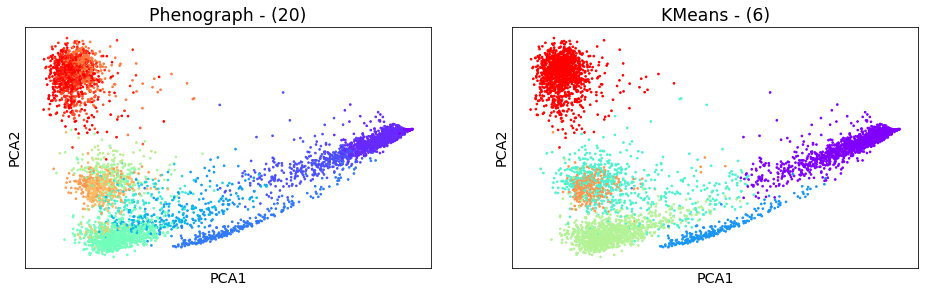

In [71]:
fig, axes = plt.subplots(1,2, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(data_pca, c=clusterings[algorithm], cmap=plt.cm.rainbow,
                        title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))), 
                        ticks=False, label_prefix="PCA", legend=False, discrete=True,
                        ax=ax)

## 2.3 Rationally choosing n_clusters

Refer back to assignment 4 to choose a good number of clusters. If you run into problems with packages, just make a decent guess.

# 3.0 Analysis

TODO: Plot the expression of each of these genes on your low-dimension cell plot (PCA, UMAP , whichever
you chose). Do each gene individually so that you have 9 small plots to take up less space, perhaps
arranged in a 3x3 grid.

FOR THE PROJECT, these will not be the best gene choices for your new dataset. Instead, use the "Differential expression" section below to find some genes that might be interesting.

### Gene list:

* Trf
* Mbp
* Ly6c1
* Clu
* Dcn
* Cspg5
* Acta2
* Meg3
* Kctd13


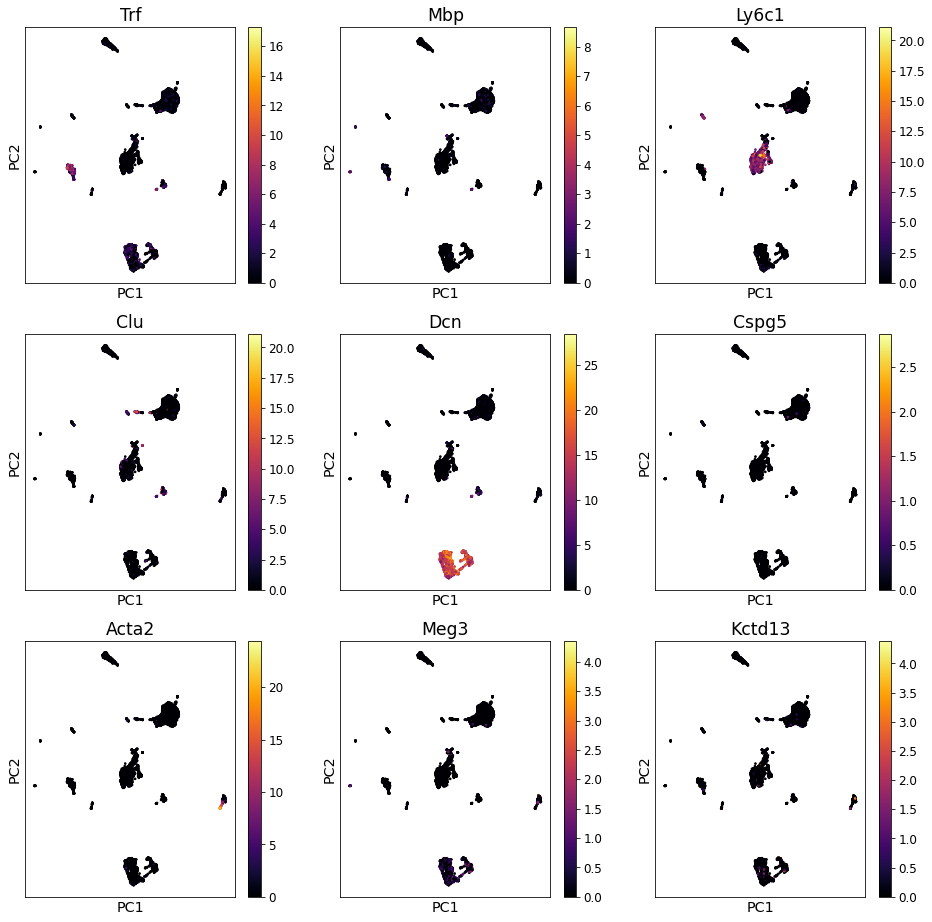

In [125]:
## TODO ##

# check the capitalization of genes in your list! 
gene_list = ['Trf','Mbp','Ly6c1','Clu','Dcn','Cspg5','Acta2','Meg3','Kctd13']

fig, axes = plt.subplots(3,3, figsize=(16,16))

for gene, ax in zip(gene_list, axes.flatten()):
  expression = scprep.select.select_cols(data, exact_word=gene)

  ## TODO ## fill in the following :) 
  scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                      title=gene, ticks=None, label_prefix='PC', ax=ax)



## 3.1 Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. Cell type is easy to grasp intuitively, but hard to formalize. Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. 

### Selecting a set of clusters

Decide on a clustering result to use for this next exercise.

In [78]:
# ==============
# choose your favorite clustering method from 'Phenograph' and 'KMeans'

## TODO -- analyze a clustering of your choice (pick whichever is your favorite!)

clusters = clusterings['KMeans']
# ==============

### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

#### Raw data

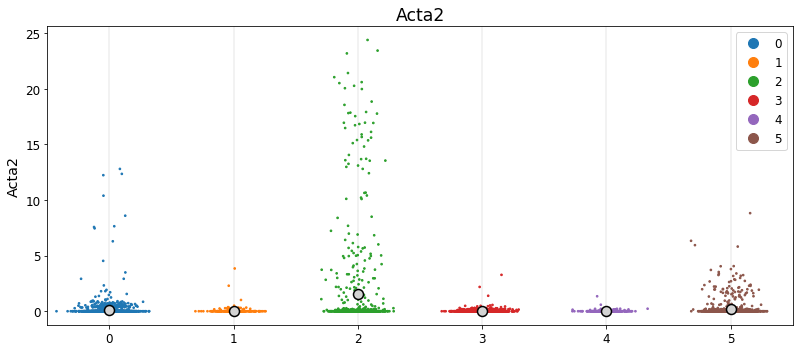

In [79]:
# example
curr_gene = 'Acta2'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

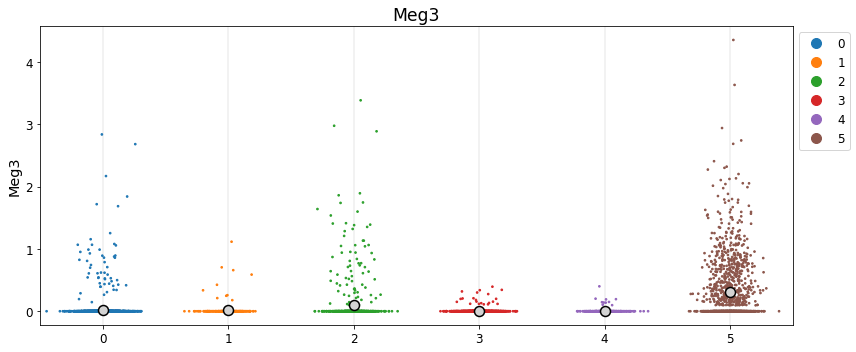

In [80]:
## TODO ##
## select an interesting gene from the list in 3.0

curr_gene = 'Meg3'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

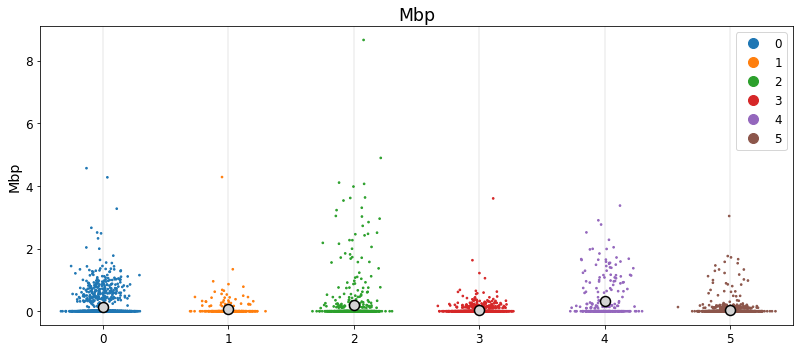

In [81]:
## TODO ##
## select another gene from the list in 3.0

curr_gene = 'Mbp'
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

## 3.2 Research

Google *one* of the genes from the list in 3.0 and tell me 

a) what type of cells express it   
b) if the cluster label from the FACS.selection matches that

In [83]:
## TODO ##
# use the following cell(s) to help with your analysis
# write in the last cell your findings

## NOTE: you may want to try running section 3.3 and seeing whether your gene and 
## is statistically different in the cluster label than in the original dataset

## NOTE: for extra strength, you might want to *quantify* the agreement 
## between your cluster and the FACS.annotation label

In [118]:
clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters
               }

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu

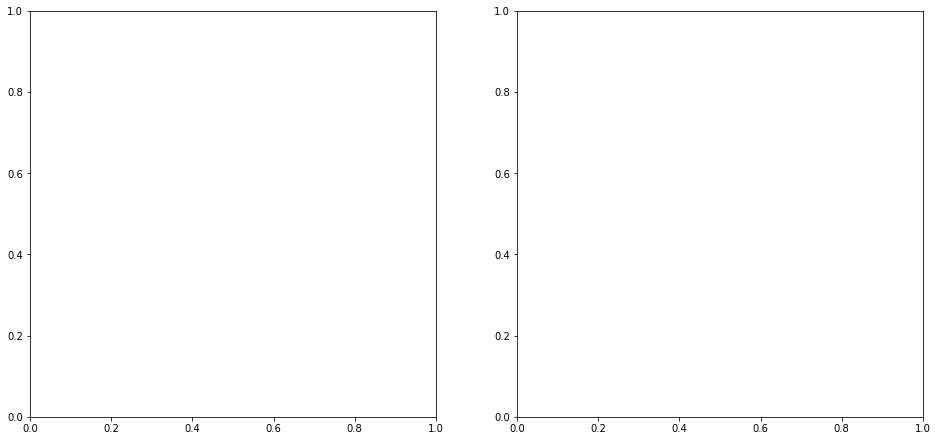

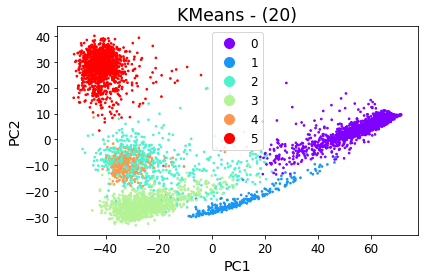

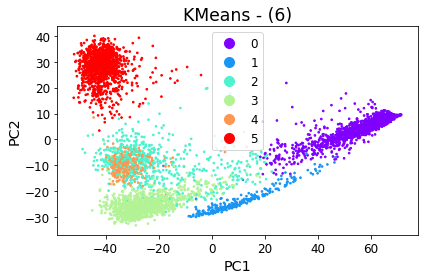

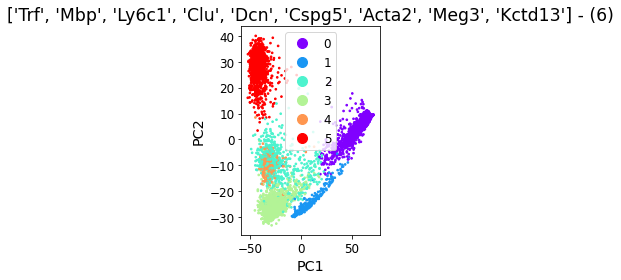

In [121]:
## NOTE: how could you modify this to visualize the 
fig, axes = plt.subplots(1,2, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(data_pca, c=clusters, cmap=plt.cm.rainbow,
                        title='{} - ({})'.format('KMeans', len(np.unique(clusterings[algorithm])), 
                        ticks=False, label_prefix="PCA", legend=False, discrete=True,
                        ax=axes))

## TODO -- modify the following to print the cell types (etc) INSTEAD OF the clusters
## hint: check the previous assignment
scprep.plot.scatter2d(data_pca, c=clusters, cmap=plt.cm.rainbow,
                      # todo -- write the name of your algorithm
                      title='{} - ({})'.format(gene_list, len(np.unique(clusters)), 
                      ticks=False, label_prefix="PCA", legend=False, discrete=True,
                      ax=axes[1]))

In [ ]:
## TODO ##
# What is your chosen gene ?
# 
# answer
# Acta2 is a gene responsible for the development of smooth muscle alpha actin
# which is a protein. 

# a) what type of cells express it   
#
# answer
# It is most often found in smooth muscle cells which are
# cells which automatically contract and expand without conscious action. As a
# result, these cells are heavily found in the heart and aorta, which are 
# constantly contracting inside the body.

# b) if the cluster label from the FACS.selection matches that.
#
# answer
# It does match.


## 3.3 Differential expression

In the above exercise, we manually inspected known marker genes to annotate clusters. Here, we're going to simply identify the genes that change the most between two groups. As discussed in lecture, there are several ways to calculate differential expression. We are going to focus on the mean-difference and the rank-sum statistic.

You can easily calculate basic differential expression statistics using `scprep.stats.differential_expression` and `scprep.stats.differential_expression_by_cluster`. More details about these methods can be found in the [documentation](https://scprep.readthedocs.io/en/stable/reference.html#scprep.stats.differential_expression).



In [88]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [92]:
## TODO ##
## pick a cluster to test
curr_cluster = 5
with tasklogger.log_task("t-test"):
    ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster], 
                                                         data_sparse[clusters != curr_cluster], 
                                                         measure='ttest')

Calculating t-test...
Calculated t-test in 39.33 seconds.


In [93]:
top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[:50]

#### Print the 20 most differentially expressed genes

In [94]:
top_genes.head(n=20)

Dcn           159.340546
Serping1      117.265628
Gsn           114.999829
Dpt           107.022004
Lum            97.167614
Fbln1          94.509218
Htra3          85.588467
Cd63           81.909367
Cfh            77.396611
Ccdc80         75.003555
Gstm1          73.673775
Loxl1          73.117305
Serpinf1       72.129663
Bgn            70.713845
Igfbp7         69.226312
Igfbp4         68.267260
Rbp1           67.921083
Rcn3           67.782913
ERCC-00096     67.540365
ERCC-00130     67.315936
Name: ttest, dtype: float64